# Resnet152 with rectangular images
### 92.45% TTA accuracy, 92.12% accuracy, 98.84% top5 accuracy on test set with 35 epochs
### 92.39% weighted Precision and 92.12% weighted Recall

Model is trained with **35 epochs** and has a **92.45% accuracy** on the test set, accuracy is achieved due to a different approach of training with **progressive resizing** and training with **rectangular images** based on the median of the aspect ratio of all images

Transfer learning is done on a pretrained ResNet-152 architecture due to the low amount of images in the training set. Training set contains 8144 images and 196 classes, averaging in 41 images per class for training and validation. With a 80:20 train-validation split, there are only around 32 images for each class to be trained on, hence making it significantly difficult to achieve a significant convergence training it from scratch (refer to EDA in the the first notebook). 
Hence transfer learning is chosen as the method for this challenge. 

#### On training with rectangular images
Training with rectangular images showed to provide a faster convergence compared to training with a fixed square 224x224 images, _fastai_ library allow custom sizing and the pretrained ResNet-152 to train on rectangular images. Initial EDA showed that the median aspect ratio for the training dataset is 3:4, training dataset is initiated with square 299x299 images followed by 299x400, and then testing with same rectangular images, achieving **92.45%** of accuracy in 35 epochs. 

A typical transfer learning process involve training the last layer before unfreezing the whole architecture for training, which would be the typical approach of freezing the pretrained model and training it for 5 epochs before unfreezing the model

#### Data Augmentation 
Perhaps the most important step that is essential in providing a better accuracy. Together with **progressive resizing** and **rectangular images training**, I have also used the default fastai images transformation, performed by calling `get_transforms()` that randomly augments the images according to their parameters: 
`do_flip` : perform flipping with probability of 0.5. I chose the default value **True** for this parameter <br>
`flip_ver` : if True flip images vertically instead, I chose **False** as it doesn't help to have a vertically flipped images<br>
`max_rotate`: I chose up to **10.0** degree rotation at random, <br>
`max_zoom`: default value of up to **1.1** zoom<br>
`max_lighting`: default value of up to **0.2** of increase/decrease in brightness or contrast<br>
`max_warp`:  default value of **0.2**<br>
`p_affine` : Probability of randomly applying affine, default value **0.75**<br>
`p_lighting` : probability of applying lighting transform, default value **0.75** <br>

During resizing, instead of cropping the images to the target size, I chose to squished/compress the images into the target size to keep the features of the images during training

In [2]:
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.vision import *

In [3]:
train_path = 'data/train/'
cropped_path = 'data/cropped_train/'
test_path = 'data/test/'
all_img_path = 'data/all_img'
CROPPED_PATH = Path(cropped_path)

#### Commence training: Stage-1 (resnet152)
- Setting up data bunch and transformations

In [3]:
tfms = get_transforms()

In [4]:
trn_df_labels = pd.read_csv('train_labels.csv',usecols=['filename','class_name'])

In [5]:
src = (ImageList
       .from_df(trn_df_labels,train_path, cols='filename')
       .split_by_rand_pct(0.2, seed=42) #Splitting to 80:20 train-val set
       .label_from_df('class_name')) #Adding the labels to the data from the df

In [6]:
data299 = (src
           .transform(tfms,size=(299,299)) #adding transformation and resizing all images to 299x299
           .databunch(bs=12) #Using batch size of 12
           .normalize(imagenet_stats)) #Normalizing the databunch to imagenet_stats

In [7]:
#Initializing the Learner by loading the data, the model and metrics required for training
learn = cnn_learner(data299, models.resnet152, metrics=[error_rate, accuracy, Precision(average='weighted'), Recall(average='weighted')]) 

Train for 5 epochs using Leslie Smith's fit one cycle, where overtime increasing the lr before decreasing back the lr and inversely for momentum can lead to super convergence faster. 

The most common ways to train a pretrained model is to remove the last layer and train the whole architecture with the pretrained weights, followed by unfreezing the rest of the model and updating the weight on the data. 

The choice of learning rate 1e-3 is chosen because a low learning rate is essential to not destroy the weights of the pretrained model

In [8]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,4.356963,3.645032,0.792383,0.207617,nan,0.207617,05:02
1,2.718966,2.034589,0.506757,0.493243,nan,0.493243,04:56
2,1.676358,1.183810,0.290541,0.709459,0.763106,0.709459,04:56
3,1.064125,0.908115,0.232187,0.767813,0.797843,0.767813,04:56
4,0.823548,0.848760,0.216216,0.783784,0.803974,0.783784,04:56


### Stage 2
Unfreezing the rest of the layers

In [8]:
learn.unfreeze()

Training for 10 more epochs with learning rate betwee 1e-5 and 1e-3

In [9]:
learn.fit_one_cycle(10,slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.946753,0.925104,0.237715,0.762285,0.793043,0.762285,06:39
1,1.237133,1.056666,0.279484,0.720516,nan,0.720516,06:37
2,1.300394,1.242457,0.348280,0.651720,nan,0.651720,06:37
3,0.931017,0.845470,0.232187,0.767813,nan,0.767813,06:37
4,0.722426,0.715556,0.203317,0.796683,0.836159,0.796683,06:36
5,0.528611,0.569576,0.159091,0.840909,0.860885,0.840909,06:37
6,0.250225,0.497737,0.135135,0.864865,nan,0.864865,06:36
7,0.163025,0.438454,0.118550,0.881450,0.894549,0.881450,06:36
8,0.110071,0.408081,0.108722,0.891278,0.902223,0.891278,06:37
9,0.065681,0.410232,0.109337,0.890663,0.900586,0.890663,06:37


Saving the model

In [10]:
learn.save('14-resnet152-cropped-1')

lr_find() is used as a quick way to plot learning rate against loss and in the chart, learning rate from 1e-6 to 1e-4 seems to be a good learning rate based on the chart to minimise training loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


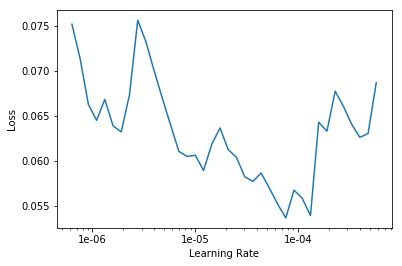

In [11]:
learn.lr_find()
learn.recorder.plot()

Training it for another 5 epochs based on the learning rate chosen from the chart

In [12]:
learn.fit_one_cycle(5, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.075135,0.397597,0.106265,0.893735,0.905368,0.893735,06:37
1,0.082872,0.404371,0.110565,0.889435,0.902594,0.889435,06:38
2,0.061445,0.409659,0.108108,0.891892,0.902999,0.891892,06:38
3,0.060745,0.403940,0.107494,0.892506,0.904370,0.892506,06:38
4,0.055910,0.398311,0.107494,0.892506,0.904397,0.892506,06:38


In [13]:
learn.save('14-resnet152-cropped-2')

Initial EDA shows that median aspect ratio in the dataset is 3:4 and it is an important information because most model is trained with squared image and it will not work with a rectangular images. FastAI library made it easier to train with a custom aspect ratio, allowing the model to be trained on rectangular images. 
Reason why square images do not work is because, when images are resized to squares, depending on the resizing method, the images either were:

1. made the images look squished 
2. cropped into the middle, losing other features for the whole image

Hence training it with images with **3:4 aspect ratio** will retain a lot of the features of the car. 

In [24]:
data_ar = (src
           .transform(tfms,size=(299,400)) #299,400 to retain the 3:4 aspect ratio
           .databunch(bs=12) 
           .normalize(imagenet_stats))

Swapping out the data in the Learner object with new rectangular images for training

In [25]:
learn.data = data_ar 

In [26]:
learn.freeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


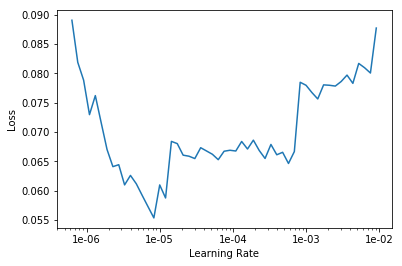

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5,2e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.052192,0.401342,0.107494,0.892506,0.903457,0.892506,06:27
1,0.055976,0.403220,0.109337,0.890663,0.900945,0.890663,06:26
2,0.059788,0.403950,0.108108,0.891892,0.902538,0.891892,06:25
3,0.063641,0.401846,0.107494,0.892506,0.904053,0.892506,06:25
4,0.065086,0.401861,0.108722,0.891278,0.901971,0.891278,06:26


Unfreezing to train the whole model and its weights

In [30]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


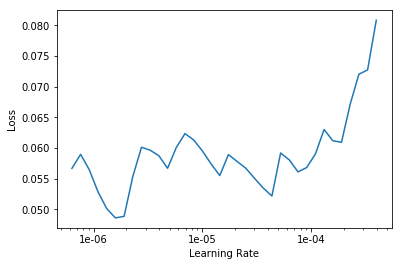

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10,slice(3e-7,3e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.058514,0.396269,0.106265,0.893735,0.903020,0.893735,08:28
1,0.069162,0.392105,0.104423,0.895577,0.906700,0.895577,08:30
2,0.052691,0.377156,0.101966,0.898034,0.907320,0.898034,08:30
3,0.049295,0.365907,0.101351,0.898649,0.908291,0.898649,08:30
4,0.043621,0.368690,0.098280,0.901720,0.910490,0.901720,08:31
5,0.039249,0.368421,0.101966,0.898034,0.906926,0.898034,08:31
6,0.031399,0.369126,0.100123,0.899877,0.909132,0.899877,08:31
7,0.042559,0.366983,0.098894,0.901106,0.909618,0.901106,08:30
8,0.040305,0.365066,0.096437,0.903563,0.911852,0.903563,08:32
9,0.048855,0.365729,0.097666,0.902334,0.911494,0.902334,08:31


Saving the model to be used for testing

In [33]:
learn.save('14-resnet152-cropped-3')

### Testing

Load test dataset

In [42]:
all_img_df = pd.read_csv('all_img.csv', usecols=['filename','class_name', 'test'])

In [9]:
prec = Precision(average='weighted')
prec.n_classes = 0
rec = Recall(average='weighted')
rec.n_classes = 0


Loading a test image, test set is used in the dataloader validation set. 

In [43]:
data_test = (ImageList
             .from_df(all_img_df,all_img_path,cols='filename')
             .split_from_df(col='test')
             .label_from_df(cols='class_name')
             .transform(size=(299,400))
             .databunch(bs=64)
             .normalize(imagenet_stats))

In [11]:
learn = cnn_learner(data299,models.resnet152,metrics=[error_rate,accuracy,top_k_accuracy,prec,rec])

In [12]:
learn.load('8-resnet152-v3');

In [13]:
learn.data = data_test

In [14]:
#rectangular
learn.validate()

[0.31520358,
 tensor(0.0788),
 tensor(0.9212),
 tensor(0.9884),
 tensor(0.9239),
 tensor(0.9212)]

 Loss: 0.31520358,
 Error rate 7.8%
 Accuracy 92.12%,
 Top5 Accuracy 98.84%
 Precision 92.39%
 Recall 92.12%